### Model overfitting
Размер тренировочного набора: 1000 (маленький размер выбран для демонстрации переобучения)

Размер валидационного набора: 10000

Модели состоят из 9 полносвязных слоев с 32 нейронами в каждом, в качестве функции активации используется ReLU

В некоторые модели так же добавлены батч-нормализация и дропаут

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 50
neuNum = 32

In [3]:
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, train=1000)

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0., neuNum=128):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, neuNum)
        self.fc2 = nn.Linear(neuNum, neuNum)
        self.fc3 = nn.Linear(neuNum, neuNum)
        self.fc4 = nn.Linear(neuNum, neuNum)
        self.fc5 = nn.Linear(neuNum, neuNum)
        self.fc6 = nn.Linear(neuNum, neuNum)
        self.fc7 = nn.Linear(neuNum, neuNum)
        self.fc8 = nn.Linear(neuNum, neuNum)        
        self.fc9 = nn.Linear(neuNum, 10)
        if batchnorm:
            self.bn1 = nn.BatchNorm1d(neuNum)
            self.bn2 = nn.BatchNorm1d(neuNum)
            self.bn3 = nn.BatchNorm1d(neuNum)
            self.bn4 = nn.BatchNorm1d(neuNum)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn1(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.relu(self.fc3(x))
        
        if self.batchnorm:
            x = self.bn2(x)
        x = F.relu(self.fc4(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.relu(self.fc5(x))   
        
        if self.batchnorm:
            x = self.bn3(x)
        x = F.relu(self.fc6(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.relu(self.fc7(x))         

        if self.batchnorm:
            x = self.bn4(x)
        x = F.relu(self.fc8(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc9(x)              
        
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def test(models, loader, log=None, Name='Test'):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data.to(device))
                test_loss[k] += m.loss(output, target.to(device), reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.to(device).data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = Name+' set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data.to(device))
            loss = model.loss(output, target.to(device))
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    test(models, train_loader, log, 'Train')

In [7]:
models = {'default': Net(False, False, neuNum=neuNum).to(device), 'bn': Net(True, False, neuNum=neuNum).to(device), 'drop': Net(False, True, neuNum=neuNum).to(device), 'both': Net(True, True, neuNum=neuNum).to(device)}
# models = {'default': Net(False, False, neuNum=neuNum).to(device), 'both': Net(True, True, neuNum=neuNum).to(device)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
for epoch in range(1, 201):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/1000 (0%)]	Losses default: 2.299528 bn: 2.286780 drop: 2.294102 both: 2.332814
Train Epoch: 1 [1000/1000 (100%)]	Losses default: 2.293767 bn: 2.310495 drop: 2.327294 both: 2.298833
Train set:
default: Loss: 2.3007	Accuracy: 115/1000 (11%)
bn: Loss: 2.3006	Accuracy: 99/1000 (9%)
drop: Loss: 2.3086	Accuracy: 99/1000 (9%)
both: Loss: 2.3034	Accuracy: 131/1000 (13%)

Test set:
default: Loss: 2.3038	Accuracy: 983/10000 (9%)
bn: Loss: 2.3040	Accuracy: 989/10000 (9%)
drop: Loss: 2.3099	Accuracy: 1036/10000 (10%)
both: Loss: 2.3149	Accuracy: 988/10000 (9%)

Train Epoch: 2 [0/1000 (0%)]	Losses default: 2.305468 bn: 2.283457 drop: 2.313330 both: 2.316305
Train Epoch: 2 [1000/1000 (100%)]	Losses default: 2.301081 bn: 2.283332 drop: 2.324880 both: 2.323676
Train set:
default: Loss: 2.3001	Accuracy: 115/1000 (11%)
bn: Loss: 2.2853	Accuracy: 106/1000 (10%)
drop: Loss: 2.3078	Accuracy: 99/1000 (9%)
both: Loss: 2.2845	Accuracy: 141/1000 (14%)

Test set:
default: Loss: 2.3034	Accuracy

Train Epoch: 15 [1000/1000 (100%)]	Losses default: 1.926171 bn: 2.125009 drop: 1.998147 both: 2.019048
Train set:
default: Loss: 1.9948	Accuracy: 254/1000 (25%)
bn: Loss: 2.0662	Accuracy: 342/1000 (34%)
drop: Loss: 1.8970	Accuracy: 390/1000 (39%)
both: Loss: 1.9705	Accuracy: 453/1000 (45%)

Test set:
default: Loss: 2.0426	Accuracy: 2204/10000 (22%)
bn: Loss: 2.1051	Accuracy: 3245/10000 (32%)
drop: Loss: 1.9340	Accuracy: 3444/10000 (34%)
both: Loss: 2.0460	Accuracy: 3953/10000 (39%)

Train Epoch: 16 [0/1000 (0%)]	Losses default: 1.873078 bn: 2.118472 drop: 1.907706 both: 1.913791
Train Epoch: 16 [1000/1000 (100%)]	Losses default: 1.902706 bn: 2.082031 drop: 1.854190 both: 1.943506
Train set:
default: Loss: 1.9517	Accuracy: 288/1000 (28%)
bn: Loss: 2.0490	Accuracy: 384/1000 (38%)
drop: Loss: 1.7295	Accuracy: 401/1000 (40%)
both: Loss: 1.9469	Accuracy: 459/1000 (45%)

Test set:
default: Loss: 2.0013	Accuracy: 2508/10000 (25%)
bn: Loss: 2.0884	Accuracy: 3591/10000 (35%)
drop: Loss: 1.7827	

Train Epoch: 29 [1000/1000 (100%)]	Losses default: 1.065583 bn: 1.614143 drop: 0.744104 both: 1.475975
Train set:
default: Loss: 1.1361	Accuracy: 598/1000 (59%)
bn: Loss: 1.5896	Accuracy: 627/1000 (62%)
drop: Loss: 0.8623	Accuracy: 750/1000 (75%)
both: Loss: 1.4960	Accuracy: 674/1000 (67%)

Test set:
default: Loss: 1.3060	Accuracy: 5394/10000 (53%)
bn: Loss: 1.6682	Accuracy: 5691/10000 (56%)
drop: Loss: 0.9970	Accuracy: 6786/10000 (67%)
both: Loss: 1.6145	Accuracy: 6341/10000 (63%)

Train Epoch: 30 [0/1000 (0%)]	Losses default: 0.972763 bn: 1.468807 drop: 0.818699 both: 1.360572
Train Epoch: 30 [1000/1000 (100%)]	Losses default: 1.200710 bn: 1.586064 drop: 1.014853 both: 1.527010
Train set:
default: Loss: 1.1136	Accuracy: 611/1000 (61%)
bn: Loss: 1.5465	Accuracy: 653/1000 (65%)
drop: Loss: 0.8398	Accuracy: 764/1000 (76%)
both: Loss: 1.4617	Accuracy: 674/1000 (67%)

Test set:
default: Loss: 1.2801	Accuracy: 5543/10000 (55%)
bn: Loss: 1.6410	Accuracy: 5754/10000 (57%)
drop: Loss: 0.9819	

Train Epoch: 43 [1000/1000 (100%)]	Losses default: 0.750095 bn: 1.121084 drop: 0.582565 both: 1.061857
Train set:
default: Loss: 0.8283	Accuracy: 743/1000 (74%)
bn: Loss: 1.0824	Accuracy: 711/1000 (71%)
drop: Loss: 0.6169	Accuracy: 831/1000 (83%)
both: Loss: 1.0065	Accuracy: 756/1000 (75%)

Test set:
default: Loss: 1.1079	Accuracy: 6543/10000 (65%)
bn: Loss: 1.2240	Accuracy: 6434/10000 (64%)
drop: Loss: 0.8009	Accuracy: 7686/10000 (76%)
both: Loss: 1.1717	Accuracy: 6984/10000 (69%)

Train Epoch: 44 [0/1000 (0%)]	Losses default: 1.142897 bn: 1.213395 drop: 0.635967 both: 1.076722
Train Epoch: 44 [1000/1000 (100%)]	Losses default: 0.660354 bn: 1.040459 drop: 0.580433 both: 1.051916
Train set:
default: Loss: 0.8104	Accuracy: 751/1000 (75%)
bn: Loss: 1.0464	Accuracy: 724/1000 (72%)
drop: Loss: 0.6067	Accuracy: 830/1000 (83%)
both: Loss: 0.9589	Accuracy: 779/1000 (77%)

Test set:
default: Loss: 1.0986	Accuracy: 6589/10000 (65%)
bn: Loss: 1.2077	Accuracy: 6480/10000 (64%)
drop: Loss: 0.7941	

Train Epoch: 57 [1000/1000 (100%)]	Losses default: 0.741406 bn: 0.617682 drop: 0.460769 both: 0.497970
Train set:
default: Loss: 0.6248	Accuracy: 824/1000 (82%)
bn: Loss: 0.7073	Accuracy: 822/1000 (82%)
drop: Loss: 0.4527	Accuracy: 878/1000 (87%)
both: Loss: 0.6139	Accuracy: 881/1000 (88%)

Test set:
default: Loss: 0.9984	Accuracy: 7157/10000 (71%)
bn: Loss: 0.9559	Accuracy: 7180/10000 (71%)
drop: Loss: 0.7127	Accuracy: 7967/10000 (79%)
both: Loss: 0.9095	Accuracy: 7754/10000 (77%)

Train Epoch: 58 [0/1000 (0%)]	Losses default: 0.687293 bn: 0.781777 drop: 0.345961 both: 0.593689
Train Epoch: 58 [1000/1000 (100%)]	Losses default: 0.555572 bn: 0.671399 drop: 0.359966 both: 0.569318
Train set:
default: Loss: 0.6199	Accuracy: 823/1000 (82%)
bn: Loss: 0.6982	Accuracy: 828/1000 (82%)
drop: Loss: 0.4374	Accuracy: 872/1000 (87%)
both: Loss: 0.6065	Accuracy: 881/1000 (88%)

Test set:
default: Loss: 0.9912	Accuracy: 7178/10000 (71%)
bn: Loss: 0.9386	Accuracy: 7235/10000 (72%)
drop: Loss: 0.7056	

Train Epoch: 71 [1000/1000 (100%)]	Losses default: 0.424772 bn: 0.557746 drop: 0.254371 both: 0.411162
Train set:
default: Loss: 0.4777	Accuracy: 882/1000 (88%)
bn: Loss: 0.4908	Accuracy: 902/1000 (90%)
drop: Loss: 0.3524	Accuracy: 895/1000 (89%)
both: Loss: 0.3710	Accuracy: 945/1000 (94%)

Test set:
default: Loss: 0.9352	Accuracy: 7493/10000 (74%)
bn: Loss: 0.8125	Accuracy: 7637/10000 (76%)
drop: Loss: 0.6951	Accuracy: 8079/10000 (80%)
both: Loss: 0.7622	Accuracy: 8040/10000 (80%)

Train Epoch: 72 [0/1000 (0%)]	Losses default: 0.413371 bn: 0.338059 drop: 0.408077 both: 0.276723
Train Epoch: 72 [1000/1000 (100%)]	Losses default: 0.404689 bn: 0.391808 drop: 0.270707 both: 0.251031
Train set:
default: Loss: 0.4731	Accuracy: 876/1000 (87%)
bn: Loss: 0.4585	Accuracy: 914/1000 (91%)
drop: Loss: 0.3410	Accuracy: 898/1000 (89%)
both: Loss: 0.3554	Accuracy: 952/1000 (95%)

Test set:
default: Loss: 0.9420	Accuracy: 7465/10000 (74%)
bn: Loss: 0.8000	Accuracy: 7693/10000 (76%)
drop: Loss: 0.6852	

Train Epoch: 85 [1000/1000 (100%)]	Losses default: 0.372200 bn: 0.272712 drop: 0.225727 both: 0.232239
Train set:
default: Loss: 0.3695	Accuracy: 915/1000 (91%)
bn: Loss: 0.2820	Accuracy: 964/1000 (96%)
drop: Loss: 0.2721	Accuracy: 922/1000 (92%)
both: Loss: 0.2088	Accuracy: 973/1000 (97%)

Test set:
default: Loss: 0.9264	Accuracy: 7589/10000 (75%)
bn: Loss: 0.7164	Accuracy: 8000/10000 (80%)
drop: Loss: 0.6958	Accuracy: 8162/10000 (81%)
both: Loss: 0.6846	Accuracy: 8242/10000 (82%)

Train Epoch: 86 [0/1000 (0%)]	Losses default: 0.259558 bn: 0.224828 drop: 0.181512 both: 0.216641
Train Epoch: 86 [1000/1000 (100%)]	Losses default: 0.308067 bn: 0.306122 drop: 0.233130 both: 0.142950
Train set:
default: Loss: 0.3634	Accuracy: 913/1000 (91%)
bn: Loss: 0.2898	Accuracy: 956/1000 (95%)
drop: Loss: 0.2823	Accuracy: 914/1000 (91%)
both: Loss: 0.2051	Accuracy: 974/1000 (97%)

Test set:
default: Loss: 0.9236	Accuracy: 7609/10000 (76%)
bn: Loss: 0.7104	Accuracy: 8046/10000 (80%)
drop: Loss: 0.7154	

Train Epoch: 99 [1000/1000 (100%)]	Losses default: 0.429686 bn: 0.142506 drop: 0.244528 both: 0.232662
Train set:
default: Loss: 0.2863	Accuracy: 936/1000 (93%)
bn: Loss: 0.2165	Accuracy: 973/1000 (97%)
drop: Loss: 0.2099	Accuracy: 946/1000 (94%)
both: Loss: 0.1402	Accuracy: 981/1000 (98%)

Test set:
default: Loss: 0.9333	Accuracy: 7685/10000 (76%)
bn: Loss: 0.6768	Accuracy: 8115/10000 (81%)
drop: Loss: 0.7246	Accuracy: 8178/10000 (81%)
both: Loss: 0.6722	Accuracy: 8265/10000 (82%)

Train Epoch: 100 [0/1000 (0%)]	Losses default: 0.387887 bn: 0.325916 drop: 0.162319 both: 0.089365
Train Epoch: 100 [1000/1000 (100%)]	Losses default: 0.216083 bn: 0.172081 drop: 0.176666 both: 0.116101
Train set:
default: Loss: 0.2819	Accuracy: 934/1000 (93%)
bn: Loss: 0.1989	Accuracy: 970/1000 (97%)
drop: Loss: 0.2097	Accuracy: 946/1000 (94%)
both: Loss: 0.1530	Accuracy: 977/1000 (97%)

Test set:
default: Loss: 0.9328	Accuracy: 7676/10000 (76%)
bn: Loss: 0.6765	Accuracy: 8130/10000 (81%)
drop: Loss: 0.730

Train Epoch: 113 [1000/1000 (100%)]	Losses default: 0.327499 bn: 0.233285 drop: 0.262901 both: 0.206321
Train set:
default: Loss: 0.2131	Accuracy: 953/1000 (95%)
bn: Loss: 0.1183	Accuracy: 986/1000 (98%)
drop: Loss: 0.1622	Accuracy: 959/1000 (95%)
both: Loss: 0.0948	Accuracy: 991/1000 (99%)

Test set:
default: Loss: 0.9556	Accuracy: 7768/10000 (77%)
bn: Loss: 0.6733	Accuracy: 8151/10000 (81%)
drop: Loss: 0.7791	Accuracy: 8137/10000 (81%)
both: Loss: 0.6934	Accuracy: 8297/10000 (82%)

Train Epoch: 114 [0/1000 (0%)]	Losses default: 0.153766 bn: 0.083084 drop: 0.171928 both: 0.058795
Train Epoch: 114 [1000/1000 (100%)]	Losses default: 0.206648 bn: 0.125978 drop: 0.124726 both: 0.087513
Train set:
default: Loss: 0.2109	Accuracy: 952/1000 (95%)
bn: Loss: 0.1237	Accuracy: 981/1000 (98%)
drop: Loss: 0.1577	Accuracy: 965/1000 (96%)
both: Loss: 0.0917	Accuracy: 988/1000 (98%)

Test set:
default: Loss: 0.9618	Accuracy: 7767/10000 (77%)
bn: Loss: 0.6654	Accuracy: 8221/10000 (82%)
drop: Loss: 0.78

Train Epoch: 127 [1000/1000 (100%)]	Losses default: 0.163106 bn: 0.118888 drop: 0.112735 both: 0.073793
Train set:
default: Loss: 0.1684	Accuracy: 963/1000 (96%)
bn: Loss: 0.0952	Accuracy: 989/1000 (98%)
drop: Loss: 0.1209	Accuracy: 974/1000 (97%)
both: Loss: 0.0931	Accuracy: 983/1000 (98%)

Test set:
default: Loss: 1.0110	Accuracy: 7755/10000 (77%)
bn: Loss: 0.6837	Accuracy: 8189/10000 (81%)
drop: Loss: 0.8310	Accuracy: 8166/10000 (81%)
both: Loss: 0.7017	Accuracy: 8324/10000 (83%)

Train Epoch: 128 [0/1000 (0%)]	Losses default: 0.234651 bn: 0.192969 drop: 0.114505 both: 0.085340
Train Epoch: 128 [1000/1000 (100%)]	Losses default: 0.123898 bn: 0.057817 drop: 0.091200 both: 0.058851
Train set:
default: Loss: 0.1558	Accuracy: 969/1000 (96%)
bn: Loss: 0.0794	Accuracy: 991/1000 (99%)
drop: Loss: 0.1226	Accuracy: 969/1000 (96%)
both: Loss: 0.0702	Accuracy: 988/1000 (98%)

Test set:
default: Loss: 1.0097	Accuracy: 7796/10000 (77%)
bn: Loss: 0.6910	Accuracy: 8194/10000 (81%)
drop: Loss: 0.83

Train Epoch: 141 [1000/1000 (100%)]	Losses default: 0.084559 bn: 0.071371 drop: 0.095523 both: 0.112977
Train set:
default: Loss: 0.1176	Accuracy: 973/1000 (97%)
bn: Loss: 0.0706	Accuracy: 989/1000 (98%)
drop: Loss: 0.0869	Accuracy: 984/1000 (98%)
both: Loss: 0.0569	Accuracy: 991/1000 (99%)

Test set:
default: Loss: 1.0590	Accuracy: 7844/10000 (78%)
bn: Loss: 0.6866	Accuracy: 8261/10000 (82%)
drop: Loss: 0.8943	Accuracy: 8137/10000 (81%)
both: Loss: 0.7339	Accuracy: 8344/10000 (83%)

Train Epoch: 142 [0/1000 (0%)]	Losses default: 0.060379 bn: 0.045654 drop: 0.045574 both: 0.037732
Train Epoch: 142 [1000/1000 (100%)]	Losses default: 0.091456 bn: 0.050482 drop: 0.125501 both: 0.050865
Train set:
default: Loss: 0.1160	Accuracy: 974/1000 (97%)
bn: Loss: 0.0568	Accuracy: 995/1000 (99%)
drop: Loss: 0.0857	Accuracy: 984/1000 (98%)
both: Loss: 0.0529	Accuracy: 989/1000 (98%)

Test set:
default: Loss: 1.0795	Accuracy: 7811/10000 (78%)
bn: Loss: 0.6775	Accuracy: 8260/10000 (82%)
drop: Loss: 0.90

Train Epoch: 155 [1000/1000 (100%)]	Losses default: 0.112539 bn: 0.030191 drop: 0.056185 both: 0.016871
Train set:
default: Loss: 0.0849	Accuracy: 986/1000 (98%)
bn: Loss: 0.0434	Accuracy: 993/1000 (99%)
drop: Loss: 0.0640	Accuracy: 990/1000 (99%)
both: Loss: 0.0467	Accuracy: 992/1000 (99%)

Test set:
default: Loss: 1.1374	Accuracy: 7839/10000 (78%)
bn: Loss: 0.6922	Accuracy: 8306/10000 (83%)
drop: Loss: 0.9622	Accuracy: 8148/10000 (81%)
both: Loss: 0.7165	Accuracy: 8389/10000 (83%)

Train Epoch: 156 [0/1000 (0%)]	Losses default: 0.075979 bn: 0.050555 drop: 0.084296 both: 0.158917
Train Epoch: 156 [1000/1000 (100%)]	Losses default: 0.031021 bn: 0.024664 drop: 0.054641 both: 0.019690
Train set:
default: Loss: 0.0778	Accuracy: 984/1000 (98%)
bn: Loss: 0.0595	Accuracy: 991/1000 (99%)
drop: Loss: 0.0614	Accuracy: 990/1000 (99%)
both: Loss: 0.0424	Accuracy: 997/1000 (99%)

Test set:
default: Loss: 1.1238	Accuracy: 7862/10000 (78%)
bn: Loss: 0.7209	Accuracy: 8253/10000 (82%)
drop: Loss: 0.97

Train Epoch: 169 [1000/1000 (100%)]	Losses default: 0.166645 bn: 0.042637 drop: 0.278327 both: 0.049463
Train set:
default: Loss: 0.0545	Accuracy: 991/1000 (99%)
bn: Loss: 0.0440	Accuracy: 994/1000 (99%)
drop: Loss: 0.0456	Accuracy: 996/1000 (99%)
both: Loss: 0.0463	Accuracy: 990/1000 (99%)

Test set:
default: Loss: 1.2073	Accuracy: 7857/10000 (78%)
bn: Loss: 0.7135	Accuracy: 8315/10000 (83%)
drop: Loss: 1.0512	Accuracy: 8107/10000 (81%)
both: Loss: 0.7277	Accuracy: 8400/10000 (84%)

Train Epoch: 170 [0/1000 (0%)]	Losses default: 0.076606 bn: 0.076801 drop: 0.029811 both: 0.061291
Train Epoch: 170 [1000/1000 (100%)]	Losses default: 0.034163 bn: 0.076337 drop: 0.029753 both: 0.051069
Train set:
default: Loss: 0.0531	Accuracy: 992/1000 (99%)
bn: Loss: 0.0354	Accuracy: 996/1000 (99%)
drop: Loss: 0.0442	Accuracy: 996/1000 (99%)
both: Loss: 0.0359	Accuracy: 992/1000 (99%)

Test set:
default: Loss: 1.2129	Accuracy: 7866/10000 (78%)
bn: Loss: 0.7042	Accuracy: 8334/10000 (83%)
drop: Loss: 1.05

Train Epoch: 183 [1000/1000 (100%)]	Losses default: 0.021409 bn: 0.016110 drop: 0.012903 both: 0.009617
Train set:
default: Loss: 0.0387	Accuracy: 997/1000 (99%)
bn: Loss: 0.0478	Accuracy: 989/1000 (98%)
drop: Loss: 0.0347	Accuracy: 997/1000 (99%)
both: Loss: 0.0413	Accuracy: 994/1000 (99%)

Test set:
default: Loss: 1.2967	Accuracy: 7873/10000 (78%)
bn: Loss: 0.7414	Accuracy: 8306/10000 (83%)
drop: Loss: 1.1165	Accuracy: 8114/10000 (81%)
both: Loss: 0.7303	Accuracy: 8422/10000 (84%)

Train Epoch: 184 [0/1000 (0%)]	Losses default: 0.024277 bn: 0.015927 drop: 0.013575 both: 0.024400
Train Epoch: 184 [1000/1000 (100%)]	Losses default: 0.023741 bn: 0.013285 drop: 0.023910 both: 0.009007
Train set:
default: Loss: 0.0363	Accuracy: 997/1000 (99%)
bn: Loss: 0.0430	Accuracy: 992/1000 (99%)
drop: Loss: 0.0325	Accuracy: 998/1000 (99%)
both: Loss: 0.0264	Accuracy: 995/1000 (99%)

Test set:
default: Loss: 1.2989	Accuracy: 7862/10000 (78%)
bn: Loss: 0.7315	Accuracy: 8321/10000 (83%)
drop: Loss: 1.11

Train Epoch: 197 [1000/1000 (100%)]	Losses default: 0.033328 bn: 0.025720 drop: 0.057749 both: 0.007421
Train set:
default: Loss: 0.0264	Accuracy: 997/1000 (99%)
bn: Loss: 0.0278	Accuracy: 994/1000 (99%)
drop: Loss: 0.0253	Accuracy: 998/1000 (99%)
both: Loss: 0.0262	Accuracy: 998/1000 (99%)

Test set:
default: Loss: 1.4043	Accuracy: 7859/10000 (78%)
bn: Loss: 0.7438	Accuracy: 8368/10000 (83%)
drop: Loss: 1.1938	Accuracy: 8104/10000 (81%)
both: Loss: 0.7368	Accuracy: 8413/10000 (84%)

Train Epoch: 198 [0/1000 (0%)]	Losses default: 0.017284 bn: 0.013880 drop: 0.017734 both: 0.022553
Train Epoch: 198 [1000/1000 (100%)]	Losses default: 0.017496 bn: 0.031575 drop: 0.024219 both: 0.015063
Train set:
default: Loss: 0.0265	Accuracy: 997/1000 (99%)
bn: Loss: 0.0210	Accuracy: 996/1000 (99%)
drop: Loss: 0.0237	Accuracy: 998/1000 (99%)
both: Loss: 0.0248	Accuracy: 994/1000 (99%)

Test set:
default: Loss: 1.3896	Accuracy: 7860/10000 (78%)
bn: Loss: 0.7298	Accuracy: 8399/10000 (83%)
drop: Loss: 1.20

In [9]:
import matplotlib.pyplot as plt

Из графика ошибок видно, что ошибка всех моделей на тренировочном наборе с течением эпох стремится к 0.

Результаты несколько отличаются от варианта с гиперболическим тангенсом. На этот раз модель с дропаутом быстрее учится, но потом всем модели сравниваются.

На эпохах 75-100 ошибки на тестовом наборе практически перестают изменятся, у моделей 'default' и 'drop' ошибки начинают увеличиваться.

Если взять уровень ошибки 0.0243 (train loss у 'default' модели на последней эпохе) и посмотреть соответствующие ошибки на тестовом наборе у различных моделей, то окажется, что ошибки сильно отличаются. Получается, что при одинаковой ошибке на тренировочном наборе обобщающая способность моделей отличается. Лучше всего с обобщением справились модели с батч-нормализацией. Модель с дропаутом так же лучше обобщает, чем модель без дропаута и батч-нормализации.

не совсем корректно делать выводы на основе одного прогона, но некоторые предварительные гипотезы сделать можно :)

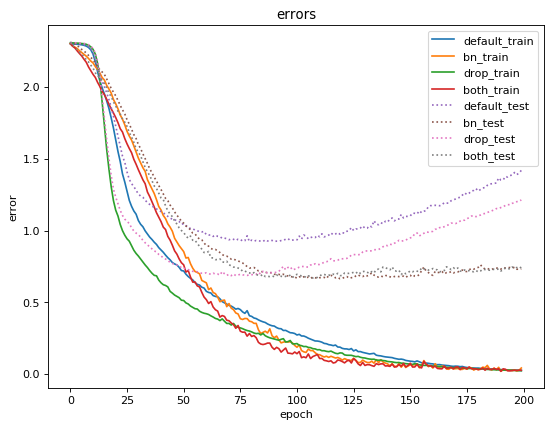

In [10]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_graphs(train_log, test_log, 'loss')

Из графика точности так же видно, что модели с батч-нормализацией учат тренировочный набор быстрее моделей без нее.

Начиная с 150 эпохи точность на тренировочном наборе практически равна 100%. Но на тестовом наборе точность намного хуже. 

Лучше всего себя показали модели с батч-нормализацией - точность 83-84%. Хуже всего модель 'default' - точность 78%. У модели с дропаутом точность 80%. На этот раз точность моделей отличается не настолько сильно.

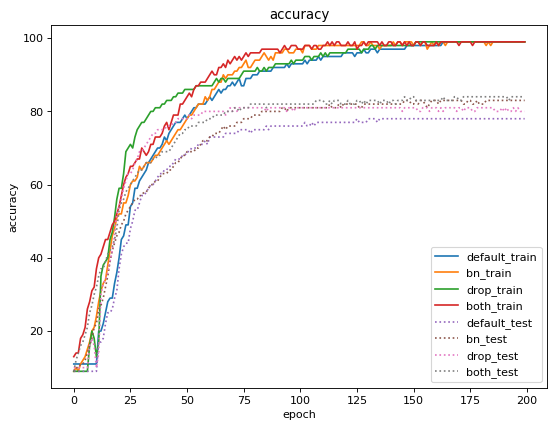

In [11]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_graphs(train_log, test_log, 'accuracy')